<div
  style="
    padding: 36px 20px 63px 20px;
    background-color: #009ee4;
    border-radius: 0 0 200px 0;
  "
>
  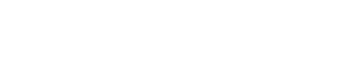

  <div
    style="
      color: white;
      margin-top: 52px;
      font-size: 56px;
      line-height: 64px;
      font-family: Arial;
    "
  >
Python для AB-тестирования
     
  </div>
</div>


## Изучим исторические данные, чтобы выбрать окно для конверсии

**Окно конверсии** – это время, которое мы даем пользователям на принятие решения. 

Например, мы знаем, что большинство наших клиентов, которые в итоге совершают целевое действие (шаг 2 после шага 1), принимают решение о нем за 2 дня. Значит нужно выделить эти два дня всем участникам теста. То есть прибавить 2 дня к тестированию после того, как мы собрали нужно число наблюдений. Важно: если человек сделал заказ на 5-ый день — этот заказ мы уже не будем учитывать.

In [ ]:
import pandas as pd

Подключимся к даным. В аргумент `pd.read_csv()` передадим, что в колонках 1 и 2 у нас дата, и что мы назначаем первый столбец исходных данных индексом. Там лежит просто нумерация строк от 0.

In [ ]:
historical_data = pd.read_csv('historical_data.csv', parse_dates = [1,2], index_col = 0)

In [ ]:
historical_data.head()

,user_id,main_page_viewed_at,order_completed_at,time_to_order
0,959238,2020-11-20 23:55:02.759000+00:00,2020-12-02 23:55:02.759000+00:00,13.375000
1,337366,2020-12-05 23:41:42.244000+00:00,2020-12-17 23:41:42.244000+00:00,10.208333
2,259956,2020-11-20 23:33:53.269000+00:00,2020-11-30 23:33:53.269000+00:00,6.708333
3,534280,2020-11-28 23:44:56.556000+00:00,2020-12-09 23:44:56.556000+00:00,9.458333
4,795121,2020-11-18 23:59:56.236000+00:00,2020-11-26 23:59:56.236000+00:00,11.916667


Подключимся к еще одной полезной для аналитики библиотеке — **NumPy.** 

**np** — стандартное имя для ее импорта, которое вы часто будете встречать в доступном коде.

In [ ]:
import numpy as np

Из **NumPy** берем функцию `percentile()`— на вход она принимает набор данных. В нашем случае: первым агрументом — столбец из датафрейма, для которых нам нужно посчитать перцентиль и вторым — значение перцентиля, которое нас интересует.

Например, если мы хотим определить 10% самых активных покупателей за прошлый месяц — по сути, нам нужно увидеть всех покупателей выше границы в 90%. Это и будет 90% перцентиль.

In [ ]:
np.percentile(historical_data['time_to_order'], 100) # сотый перцентиль - значение для всей выборки

20.95833333333333

In [ ]:
np.percentile(historical_data['time_to_order'], 95) # значение для 95% выборки

10.458333333333334

In [ ]:
np.percentile(historical_data['time_to_order'], 85) # значение для 85% выборки

2.9246527777777755

Разница между 95 и 85 перцентилем довольно большая — кажется логичным взять 85 перцентиль для дальнейшего исследования окна конверсии. Но в целом, вы всегда выбираете это значение сами.

Чтобы было удобнее работать с числами, округлим их до одного знака после запятой функцией `round()`.

In [ ]:
perc_85 = round(np.percentile(historical_data['time_to_order'], 85), 1)

Перцентили удобно смотреть на графиках, чтобы видеть распределение — поэтому подключимся к библиотекам визуализации.

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

Строим гистограмму с помощью функции `sns.distplot()` библиотеки **seaborn**

Чтобы удобно было читать график, зададим легенду с помощью `f-строк`: они делают то же, что метод `format`. С его помощью выведем в легенду значение, которое передается графику перцентиля:

    label = f'85-ый перцентиль – {perc_85} дней'

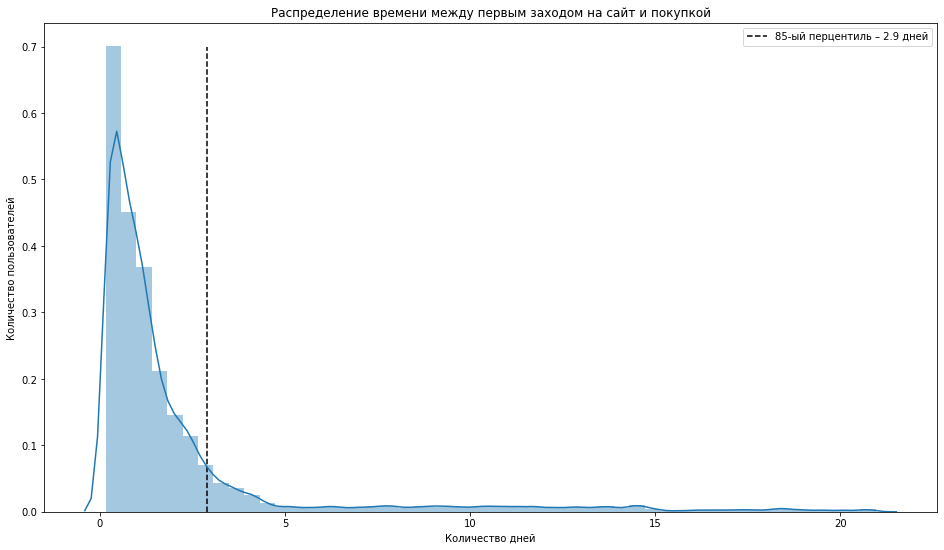

In [ ]:
plt.figure(figsize=(16,9))
sns.distplot(historical_data['time_to_order'])
plt.vlines(perc_85, ymin = 0, ymax = 0.7, linestyles = 'dashed', label = f'85-ый перцентиль – {perc_85} дней')
plt.title('Распределение времени между первым заходом на сайт и покупкой')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

<div
  style="
    padding: 24px;
    background-color: #009ee4;
    border-radius: 24px;
    color: white;
    font-family: Arial;
  "
>
  <div style="font-size: 32px; line-height: 32px; font-weight: bold">
    Подведем итоги
  </div>

  <div style="margin-top: 16px; font-size: 18px; line-height: 24px">
      Возьмем 3 дня в качестве окна для конверсии, так как 85% пользователей делают заказ именно в этот период
       
   
  </div>
</div>


## **Исследуем распределение пользователей по группам по основным сегментам**

Если наши пользователи будут распределены по сегментам неравномерно — есть риск, что факторы принадлежности к одному из сегментов повлияют на результат теста. Например, в регионах у нас меньше конкурентов, чем в Москве, и в целом пользователи более лояльные. 

Сегменты — это группы пользователей, сформированные по неким свойствам, общим для всей группы.

- по гео-группе: из какой страны, города, района наши пользователи
- по маркетиноговому каналу привлечения: платный трафик, соцсети, органический, рекламная акция
- по демографи: пол, возраст
- по особенностям поведения: регулярность покупок, средний чек и т.д.

### Подключимся к данным нашего теста

In [ ]:
data = pd.read_csv('ab_data.csv', index_col = 0)

В колонке `created_order_in_3_days` 
- 0 — для пользователей, которые ничего не купили в течение трех дней 
- 1 — для тех, кто совершил покупку в отведенное окно конверсии

In [ ]:
data.head()

,user_id,test_group,created_order_in_3_days,order_sum,geo_group,marketing_group
0,1057393,test,0.0,NaN,regions,context_brand
1,1005901,control,0.0,NaN,msk,context_brand
2,1049074,test,0.0,NaN,regions,organic
3,1027399,control,0.0,NaN,regions,context_brand
4,1060042,test,0.0,NaN,regions,social_media


В колонке `test_group` у каждого пользователя проставлен статус: был он в тестовой группе или в контрольной. 

Посчитаем для каждой группы: 
- количество ползователей `'user_id': 'count'`
- сумма единиц — количество пользователей, которые совершили покупку в рамках окна конверии в 3 дня `'created_order_in_3_days': 'sum'`

И добавим новый столбец с конверсией в обеих группах. Количество купивших разделим на общее количество в группе.

In [ ]:
metrics = data.groupby('test_group', as_index= False).agg({'user_id': 'count', 'created_order_in_3_days': 'sum'})
metrics['conversion'] = round(metrics['created_order_in_3_days']/metrics['user_id']*100, 2)
metrics

,test_group,user_id,created_order_in_3_days,conversion
0,control,10222,3119.0,30.51
1,test,10367,3369.0,32.50


In [ ]:
import seaborn as sns

Мы хотим быстро посмотреть распределение сегментов в обеих группах. Для этого напишем функцию, которая строит столбиковую диаграмму по сегментам для каждой группы.

- по оси x график выводит сегмент, который мы передадим
- по оси y график выводит количество пользователей
- в данных мы сгруппируем количество пользователей по тестовой и контрольной группе 



In [ ]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['user_id'].count().reset_index()
        sns.catplot(x = segment, 
                    y = 'user_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data, 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5) # задаем ширину столбца
    

Функции, которая у нас получилась, передаем 3 аргумента:

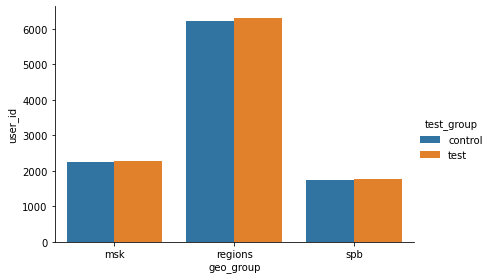

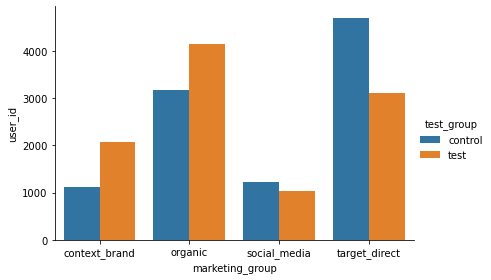

In [ ]:
plot_segments_distribution(data, #датафрейм
                           ["geo_group", "marketing_group"], #сегменты
                           "test_group") #тест-фактор

Пользователи распределены неравномерно. 

Чтобы оценить, насколько это смещение повлияет на анализ теста, посмотрим на конверсию в каждой маркетинговой группе:

In [ ]:
metrics = data.groupby('marketing_group', as_index= False).agg({'user_id': 'count', 'created_order_in_3_days': 'sum'})
metrics['conversion'] = round(metrics['created_order_in_3_days']/metrics['user_id']*100, 2)
metrics

,marketing_group,user_id,created_order_in_3_days,conversion
0,context_brand,3197,1040.0,32.53
1,organic,7317,2605.0,35.60
2,social_media,2262,646.0,28.56
3,target_direct,7813,2197.0,28.12


<body>
  <div style="padding: 24px; background-color: #ff7775; border-radius: 24px">
    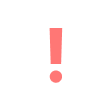
    <div
      style="
        font-size: 18px;
        line-height: 26px;
        font-family: Arial;
        color: white;
        margin-left: 84px;
      "
    >
      Распределение пользователей по группам смещено по маркетинговым каналам. Например, в тестовой группе больше пользователей из группы organic, которые демонстрируют более высокую конверсию. 
    </div>
  </div>
</body>




<div
  style="
    padding: 24px;
    background-color: #009ee4;
    border-radius: 24px;
    color: white;
    font-family: Arial;
  "
>
  <div style="font-size: 36px; margin-top: 6px; line-height: 16px; font-weight: bold">
    Решение
  <div style=" font-size: 18px; line-height: 24px">
       <br />
    1. Починим сплитование — механизм распределения пользователей по группам. 
        <br />
    2. Перезапустим эксперимент и наберем новые данные.
      

</div>


## Проверим распредление после перезапуска эксперимента

Подключимся к данным после исправления сплитования — метода, который распределеяет пользователей по группам:

In [ ]:
data = pd.read_csv('ab_data_restarted.csv', index_col = 0)

In [ ]:
data.head()

,user_id,test_group,created_order_in_3_days,order_sum,geo_group,marketing_group
39152,1005040,control,1,5194.269328,msk,target_direct
19680,1069723,test,0,NaN,msk,target_direct
6738,1064653,test,0,NaN,msk,target_direct
12480,1063744,test,1,18940.000000,msk,organic
6626,1022929,control,0,NaN,spb,social_media


Снова посчитаем количество заказов и конверсию в обеих группах:

In [ ]:
metrics = data.groupby('test_group', as_index= False).agg({'user_id': 'count', 'created_order_in_3_days': 'sum'})
metrics['conversion'] = round(metrics['created_order_in_3_days']/metrics['user_id']*100, 2)
metrics

,test_group,user_id,created_order_in_3_days,conversion
0,control,5062,1594,31.49
1,test,4938,1583,32.06


Вызовем функцию и построим графики распределения для новых данных:

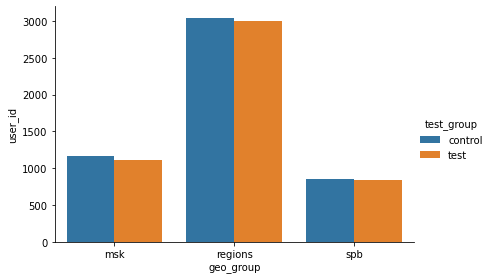

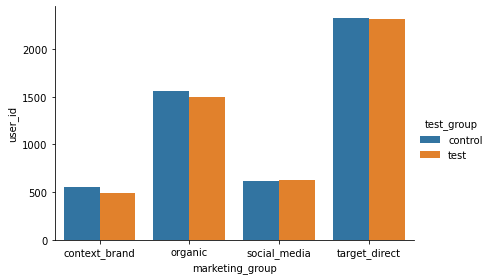

In [ ]:
plot_segments_distribution(data, ["geo_group", "marketing_group"], "test_group")

<div
  style="
    padding: 24px;
    background-color: #009ee4;
    border-radius: 24px;
    color: white;
    font-family: Arial;
  "
>
  <div style="font-size: 36px; margin-top: 6px; line-height: 16px; font-weight: bold">
    Результат
  <div style=" font-size: 18px; margin-top: 24px; line-height: 24px">
    Распределение выровнялось — можем продолжить работу с данными.

      

</div>



## Используем критерий Хи-квадрат для конверсии

Мы поняли, что собранные данные правильно распределены по сегментам. Теперь пришло время оценить, насколько разница в конверсии, которую мы получили на собранных данных, статистически значима. То есть, можем ли мы быть уверены, что разница, которую мы наблюдаем — неслучайная. 

Для такого анализа используют статистические критерии — они бывают разными для разных данных. 

Хи-квадрат — критерий, который подходит для оценки конверии, поскольку данные конверсии дискретные: пользователь либо совершил покупку, и мы присвоили ему 1, либо не совершил и мы присвоили ему 0.

Функция, которая нам нужна, чтобы использовать хи-квадрат, есть в библиотеке — `statsmodels`. Мы импортируем из нее объект `stats.proportion`, который позволяет считать пропорции. 

In [ ]:
import statsmodels.stats.proportion as proportion

Статистический критерий вернет нам значение **p-value**, которое поможет оценить: есть ли статистическая значимость в разнице конверсий, которую показывает наш эксперимент. 

### Посчитаем p-value

Передаем функции **proportions_chisquare( )** параметры:

1. Количество покупок в наших группах — значения колонки `'created_order_in_3_days'`
2. Количество наблюдений — всех пользователей из колонки `'user_id'`

Так как функция возврщает три значения, мы сразу создадим три переменные через запятую:

- `chi2stat` — статистика под капотом критерия
- `pval` — интересующее нас значение p-value
- `table` — таблица сопряженности: она помогает исследовать связи в распределениях, но в данной задаче она нам не понадобится

In [ ]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['created_order_in_3_days'], metrics['user_id'])

Так как ни один статистический критерий не дает 100% уверенности, мы зададим ему порог 5% для ошибки первого рода — то есть согласимся, что 5% наших наблюдений будут ошибочными.

In [ ]:
alpha = 0.05

`p-value` — это фактическая вероятность попасть в ошибку первого рода на наших данных, если мы отклоним нулевую гипотезу. Давайте **сравним p-value c желаемым уровнем точности нашего эксперимента.** 

- Если **p-value меньше** порога ошибки первого рода — результат эксперимента можно считать статзначимым
- Если **p-value больше** — мы будем вынуждены признать разницу в значениях тестовой и контрольной группы случайной

In [ ]:
print(pval < alpha)

False


<div
  style="
    padding: 24px;
    background-color: #009ee4;
    border-radius: 24px;
    color: white;
    font-family: Arial;
  "
>
  <div style="font-size: 36px; margin-top: 6px; line-height: 16px; font-weight: bold">
    Результат
  <div style=" font-size: 18px; margin-top: 24px; line-height: 24px">
    Статистически значимой разницы в конверсии не обнаружено, так как p-value выше выбранного порога ошибки первого рода

      

</div>



## Используем Bootstrap для среднего чека

Прежде чем делать выводы, проверим, нет ли значимого изменения среднего чека, ведь конверсия и средний чек — метрики, которые тесно связаны: если улучшить одну — другая может стать хуже.

Для среднего чека не подходит хи-квадрат, так как эта метрика не дискретная: у среднего чека большой разброс значений на разных пользователей, которые редко распределены нормально. Поэтому т-тест тоже не подходит. 

Здесь поможет метод **bootstrap.**

Он уже реализован в библиотеке `bootstrapped` — скачаем ее:

In [2]:
# скачиваем библиотеку с помощью !pip
!pip install bootstrapped

  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=7ecf25dfc066d06e381d468370ce3ee67d000f33155f086ce8bbce7711e0799b
  Stored in directory: c:\users\1645295\appdata\local\pip\cache\wheels\a9\7b\e9\000ad8cb18a35a7d68051b362c96a867cd24b7b0c7b478329d
Successfully built bootstrapped


In [3]:
# импортируем необходимые модули
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

Нам понадобится функция `bootstrap_ab`. Чтобы подготовить данные, давайте посмотрим, какие аргументы она принимает:

In [ ]:
# посмотрим подсказку, какие аргументы принимает функция

??bs.bootstrap_ab

Первый аргумент — `test` — массив с данными тестовой группы.

Наши данные в датафрейме `data` — не подходят, так как в них тестовая и контрольная группы вместе. Кроме того, есть пользователи без покупок — их не нужно учитывать в подсчете среднего чека. 

- отделим только тестовых пользователей
- удалим пустые значения, то есть пользователей, не сделавших покупку
- `.values` превратит серию в массив

*Массив — это структура  данных, которая похожа на списки. Но в отличие от них массивы хранят только данные одного типа. Например, только строки или только числовые данные*. 

In [ ]:
test = data[data['test_group'] == 'test']['order_sum'].dropna().values

Второй аргумент — `ctrl` — массив с данными контрольной группы.

- отделим только пользователей из контрольной группы
- удалим пустые значения, то есть пользователей, не сделавших покупку
- `.values` превратит серию в массив

In [ ]:
ctrl = data[data['test_group'] == 'control']['order_sum'].dropna().values

Также нам понадобятся аргументы:


- `stat_func = bs_stats.mean` — что мы хотим исследовать. В нашем случае — среднее значение

- `compare_func = bs_compare.difference`— как мы хотим исследовать. В нашем случае — хотим взять разницу между группами 

- `return_distribution = True` — вернем набор разниц, который функция получает в результате всех итераций

Чтобы сохранить то, что возвращает функция, запишем результат ее работы в переменную `boot_results`

In [ ]:
boot_results = bs.bootstrap_ab(test = test, ctrl = ctrl
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)

Мы получили массив разниц в средних чеках между нашими группами.

In [ ]:
boot_results

array([248.91473862,  63.90327865, 163.11416896, ..., 308.54986974,
       240.94066474, 403.8549362 ])

### Доверительный интервал

Значение среднего чека, которое мы получили для обеих групп, верно только для тех групп пользователей, которые пришли в течение эксперимента. Если бы в эксперименте участвовали похожие, но другие пользователи — значение среднего чека немного, но отличалось бы. Понять, насколько могут отличаться похожие группы в нашем эксперименте, поможет доверительный интервал.

Уровень доверия обычно устанавливают в 95%. То есть можно сказать, что в 95% аналогичных экспериментов конверсия будет колебаться внутри этого интервала. 



**Зададим границы доверительного интервала от 2,5 до 97,5 — между ними как раз 95%.**


In [ ]:
borders = np.percentile(boot_results, [2.5, 97.5]) # считаем перцентили
borders

array([-122.65652106,  498.93164707])

Используем полученный выше массив в переменной `boot_results`, чтобы выяснить доверительный интервал — то есть тот интервал колебаний среднего чека похожих экспериментов.

Если ноль не входит в доверительный интервал, аналогично условию `p-value < alpha` — разница значима.

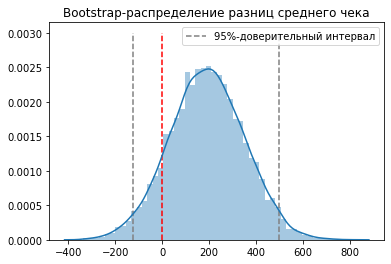

In [ ]:
sns.distplot(boot_results) # функция построения распределения
plt.title('Bootstrap-распределение разниц среднего чека')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(borders, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

<div
  style="
    padding: 24px;
    background-color: #009ee4;
    border-radius: 24px;
    color: white;
    font-family: Arial;
  "
>
  <div style="font-size: 36px; margin-top: 6px; line-height: 16px; font-weight: bold">
    Результат
  <div style=" font-size: 18px; margin-top: 24px; line-height: 24px">
    Статистически значимой разницы в среднем чеке не обнаружено, так как 0 входит в доверительный интервал разницы между группами

      

</div>



## Вычислим мощность при использовании критерия хи-квадрат

**Мощность** — это вероятность увидеть разницу там, где она существует.

С помощью хи-квадрата посчитаем вероятность увидеть статистически значимые отличия в нашем эксперименте. 
 
У любого статистического критерия есть формула, по которой связаны:

- значение метрики — конверсия в каждой группе
- размер выборки  — количество наблюдений (nobs)
- уровень значимости — вероятность ошибки первого рода
- мощность — вероятность заметить изменение, если оно есть

Зная три параметра, мы можем вычислить четвертый. Сейчас это — мощность. 

Импортируем из `statsmodels` объект `stats.power`, в котором есть нужные нам функции:

In [ ]:
import statsmodels.stats.power as smp

Присвоим переменной объект `.GofChisquarePower( )` из этой библиотеки, чтобы к нему было удобнее обращаться.

И посмотрим подсказку по нужной нам функции `.solve_power( )`

In [ ]:
# посмотрим подсказку, какие аргументы нам нужно подготовить

chipower = smp.GofChisquarePower()
??chipower.solve_power

Подготовим данные для аргументов:

In [ ]:
#конверсия в контрольной группе
conversion_control = metrics['conversion'].values[0]/100 

#конверсия в тестовой группе
conversion_test = metrics['conversion'].values[1]/100

# в столбце 2 значения: кол-во наблюдений для каждой группы — возьмем то, что меньше
nobs = min(metrics['user_id'])

`effect_size` — это особая разница в коэффициентах конверсии в двух группах. То есть то, на сколько одна группа эффективнее другой в исследуемой метрике. Это не просто разность между итоговым значением двух групп. Вычисляем так: 

$$ES = \sqrt{(p_0 - p_1)^2/p_o}$$

, где под $p_0$ можно понимать конверсию в контрольной группе, а $p_1$ — в тестовой

**Перенесем эту формулу в функцию:**

In [ ]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

0.010157539628530998

Вызовем нашу функцию и передадим ей все аргументы. Искомому значению мы присваиваем `None` — функция вернет именно это значение.

Здесь мы присвоим `alpha = pval`, то есть значение p-value для наших данных. Мы хотим посмотреть фактическую мощность, которую получили — поэтому передаем не желаемое, а реальное значение вероятности ошибки первого рода.

In [ ]:
chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test), # разница коэффициентов конверсии
                                               nobs = nobs, # размер выборки
                                               alpha = pval, # значение ошибки первого рода на наших данных
                                               power = None) # функция вернет значение, указаное как None

NameError: name 'effect_size' is not defined

<body>
  <div style="padding: 24px; background-color: #ff7775; border-radius: 24px">
    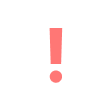
    <div
      style="
        font-size: 18px;
        line-height: 26px;
        font-family: Arial;
        color: white;
        margin-left: 84px;
      "
    >
      Мощность достаточно низкая: с вероятностью более, чем 36% мы бы не увидели статистически значимых отличий там, где они существуют.      <div>Стандартное значение мощности — 80% и выше</div>
    
   </div>
  </div>
</body>




## Вычислим количество наблюдений, чтобы получить желаемый уровень мощности

Для этого используем ту же функцию, но оставляем неизвестным аргумент  `nobs`. 

Здесь мы уже передаем в `alpha = alpha`, которое задали, как 0,05. То есть 5%, так как хотим узнать желаемое количество наблюдений.

In [ ]:
power = 0.8 # хотим мощность не меньше 80%

In [ ]:
size_of_each_test_group = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test), 
                                               nobs = None, 
                                               alpha = alpha, 
                                               power = power) 
print('Необходимый размер выборки для эксперимента - {:.0f}'.format(2*size_of_each_test_group))

<div
  style="
    padding: 24px;
    background-color: #009ee4;
    border-radius: 24px;
    color: white;
    font-family: Arial;
  "
>
  <div style="font-size: 32px; line-height: 32px; font-weight: bold">
    Решение
  </div>

  <div style="margin-top: 16px; font-size: 18px; line-height: 24px">
    Продолжить набор данных в течение двух недель, дождаться закрытия конверсионного окна в три дня и подвести итоги эксперимента.
   
  </div>
</div>


